# Interaction with the World Homework (#3)
Python Computing for Data Science (c) J Bloom, UC Berkeley 2018

Due Tuesday 2pm, Feb 20, 2018

# 1) Monty: The Python Siri

Let's make a Siri-like program (call it Monty!) with the following properties:
   - record your voice command
   - use a webservice to parse that sound file into text
   - based on what the text, take three different types of actions:
       - send an email to yourself
       - do some math
       - tell a joke

So for example, if you say "Monty: email me with subject hello and body goodbye", it will email you with the appropriate subject and body. If you say "Monty: tell me a joke" then it will go to the web and find a joke and print it for you. If you say, "Monty: calculate two times three" it should response with printing the number 6.

Hint: you can use speed-to-text apps like Houndify (or, e.g., Google Speech https://cloud.google.com/speech/) to return the text (but not do the actions). You'll need to sign up for a free API and then follow documentation instructions for using the service within Python. 

### Record and input text for Monty

In [16]:
# First we need to record a voice command. The code for this was in lecture, so let's make a function:
def record_audio(speech_file,time=5):
    '''
    This will record audio to filename speech_file for the number of seconds specified by time.
    Please pass speech_file as a string with .wav file extension.
    '''
    # Set up some parameters
    import pyaudio
    chunk = 1024
    # Must be 16 to interface with google api
    FORMAT = pyaudio.paInt16
    CHANNELS = 1
    RATE = 44100
    RECORD_SECONDS = time
    WAVE_OUTPUT_FILENAME = speech_file
    p = pyaudio.PyAudio()
    
    # Get the data
    stream = p.open(format = FORMAT,
        channels = CHANNELS,
        rate = RATE,
        input = True,
        frames_per_buffer = chunk)
    all = []
    print("Start recording")
    for i in range(0, int(RATE / chunk * RECORD_SECONDS)):
        data = stream.read(chunk)
        all.append(data)
    print("Done recording")
    stream.close()
    p.terminate()
    
    # Export to file.
    import wave
    data = b"".join(all)
    wf = wave.open(WAVE_OUTPUT_FILENAME, "wb")
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(data)
    wf.close()

In [17]:
# This is from https://cloud.google.com/speech/docs/sync-recognize#speech-sync-recognize-python
# I did not write this, but it is to go from speech to text.

# To get this to work, must set environment properly in shell. Open jupyter notebook from the same folder!
# export GOOGLE_APPLICATION_CREDENTIALS="./MyFirstProject-c5d149b85549.json", or your credentials.

# Return a string of the transcript
def transcribe_file(speech_file):
    """Transcribe the given audio file.
    Returns a string with the results."""
    import io
    from google.cloud import speech
    from google.cloud.speech import enums
    from google.cloud.speech import types
    client = speech.SpeechClient()

    with io.open(speech_file, 'rb') as audio_file:
        content = audio_file.read()

    audio = types.RecognitionAudio(content=content)
    config = types.RecognitionConfig(
        encoding=enums.RecognitionConfig.AudioEncoding.LINEAR16,
        sample_rate_hertz=44100,
        language_code='en-US')

    response = client.recognize(config, audio)
    # Each result is for a consecutive portion of the audio. Iterate through
    # them to get the transcripts for the entire audio file.
    string_out = ""
    for result in response.results:
        # The first alternative is the most likely one for this portion.
        string_out += result.alternatives[0].transcript
        
    return str(string_out)

### Define functions for Monty

In [37]:
# Now define the three functions that Monty can do:

# First mail:
def mail(sender, pwd, to, subject, text):
    '''
    Will send an email from sender to to.
    Must be gmail account.
    Requires password as pwd.
    Subject and text should be strings.
    '''
    import smtplib
    # I found this to be simpler than in the example.
    from email.message import EmailMessage
    
    msg = EmailMessage()
    # Set the text
    msg.set_content(text)
    
    msg['Subject'] = subject
    msg['From'] = sender
    msg['To'] = to
    
    # Note that we need to designate the remote SMTP server we want to use.
    mailServer = smtplib.SMTP("smtp.gmail.com", 587)
    mailServer.starttls()
    mailServer.login(sender, pwd)
    mailServer.send_message(msg)
    mailServer.close()    

# Now math:
def quick_maths(text):
    '''
    This will take in a text file, parse it, then do the math.
    If you input words, if can only do very specific math: One word, one operation, one word.
    Otherwise, it can do any combination.
    It will return the evaluation of the math in text.
    '''
    ################################################################################### 
    # This is only needed if the text to speech spits out words, which it seems not to.
    ################################################################################### 
    # First we have to parse the string
    #str_list = text.split()
    # Define a dictionary for numbers.
    #num_dict = {
    #    "zero":0, "one":1, "two":2, "three":3, "four":4, "five":5, "six":6, "seven":7, "eight":8,
    #    "nine":9, "ten":10, "eleven":11, "twelve":12, "thirteen":13, "fourteen":14, "fifteen":15,
    #    "sixteen":16, "seventeen":17, "eighteen":18, "nineteen":19,
    #}
    
    # In the case where we get words, parse them:
    # We know the first two elements will be Monty: Caculate
    # The third and fifth are numbers, and the fourth is an operation.
    #n1 = num_dict[str_list[2]]
    #n2 = num_dict[str_list[4]]
    
    # Now we define a dictionary of allowable operators:
    # Over is a weird way to say divided by, but we can't have two words...
    #import operator
    #operator_dict = {'plus':operator.add(n1,n2),'minus':operator.sub(n1,n2),
    #                 'times':operator.mul(n1,n2),'over':operator.truediv(n1,n2)}
        
    #ans = operator_dict[str_list[3]]
    
    ################################################################################### 
    # It seems that we actually get numbers, so use eval, but carefully.
    ################################################################################### 
    # Split the text into a list of strings
    str_list = text.split()
    # If the list of strings contains divided by or times, or x, but those as operators:
    if 'divided' in str_list:
        text = text.replace('divided by','/')
    if 'x' in str_list:
        text = text.replace('x','*')
    if 'times' in str_list:
        text = text.replace('times','*')
    # Now erase all characters that are not numbers or operators:
    table = str.maketrans("","",'ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz ?!&\'')
    math_text = text.translate(table)
    
    # Now use eval and hope it doesn't break!
    ans = eval(math_text)
    return(ans)
    
# Finally joke:
def joke():
    ''' Tell a joke! '''
    return('What is Beethoven\'s favourite fruit?\nBA NA NA NAaaa')

### Test recording and outputting audio

In [19]:
# Test audio
record_audio('test.wav')
string = transcribe_file('test.wav')

Start recording
Done recording


### Test each function:

In [45]:
import my_credentials
# Test email function:
mail(sender=my_credentials.GMAIL_USERNAME,
    pwd=my_credentials.GMAIL_PASSWORD, 
    to=["micbru@berkeley.edu",],   # include an extra comma in the "to" list to 
                                   # account for the COMMASPACE.join(to)
    subject="Email from Python", 
    text="Whoooo!\n", 
    )

In [50]:
# Test joke function:
print(joke())

What is Beethoven's favourite fruit?
BA NA NA NAaaa


In [38]:
# Test maths:
quick_maths("Monty Calculate 2 times 2 x 2 divided by 4")

2.0

### The Monty Function

In [46]:
# import my credentials to get this to work:
import my_credentials

# Make a single function for Monty that will listen in, parse the audio file, then take the appropriate action.
def monty(time=5,fname='monty.wav',email=my_credentials.GMAIL_USERNAME,
          pwd=my_credentials.GMAIL_PASSWORD,to="micbru@berkeley.edu"):
    '''
    Optional inputs are time of recording and name of .wav file we will save to,
        as well as email address to send to and from and password.
    The voice input only accepts: Monty: email _text_, email with subject ___ and body ____,
        if it includes the word calculate it will use those number, and if it includes the 
        word joke Monty will tell a joke.
    '''
    # Record the audio and transcribe it to string
    record_audio(fname)
    text = transcribe_file(fname)
    # For feedback:
    print(text)
    
    # Now split the string up:
    str_list = text.split()
    
    # The 0th element should be Monty. The first should be email, or there should be the word joke.
    if 'calculate' in str_list:
        out = quick_maths(text)
    elif 'email' in str_list:
        # If the word subject exists in the phrase, find the custom subject and body.
        # This accepts email as 
        # Else, use "From python"
        if 'subject' in str_list:
            i_subject = str_list.index('subject')
            i_body = str_list.index('body')
            # Exclude the word subject and the "and body"
            subject = ' '.join(str_list[i_subject+1:i_body-1])
            body = ' '.join(str_list[i_body+1::])
            mail(email, pwd, to, subject, body)
        else:
            mail(email, pwd, to, 'From Python', text)
        out = "Email sent to {}".format(to)
    elif 'joke' in str_list:
        out = joke()
    else:
        out = ""
        print("I'm sorry, I don't understand your command: \n ")
        print(text)
    # Now print "out"
    print(out)

In [41]:
# Test the Monty function!
# The idea here is that you say "calculate" for that file, "email" for that file, "joke" for that file
# but of course this isn't necessary.
monty(fname='calculate.wav',time=15)
monty(fname='email.wav',time=25)
monty(fname='joke.wav',time=15)

Start recording
Done recording
multi calculate 2 * 2 + 3 - 1 / 1
6.0
Start recording
Done recording
what is an email with subject hi and body how's it going
Email sent to micbru@berkeley.edu
Start recording
Done recording
multi tell me a joke
What is Beethoven's favourite fruit?
BA NA NA NAaaa


# 2) Write a program that identifies musical notes from sound (AIFF) files. 

  - Run it on the supplied sound files (12) and report your program’s results. 
  - Use the labeled sounds (4) to make sure it works correctly. The provided sound files contain 1-3 simultaneous notes from different organs.
  - Save copies of any example plots to illustrate how your program works.
  
  https://piazza.com/berkeley/spring2018/ay250class13410/resources -> Homeworks -> hw3_sound_files.zip

Hints: You’ll want to decompose the sound into a frequency power spectrum. Use a Fast Fourier Transform. Be care about “unpacking” the string hexcode into python data structures. The sound files use 32 bit data. Play around with what happens when you convert the string data to other integer sizes, or signed vs unsigned integers. Also, beware of harmonics.

In [11]:
%matplotlib inline

In [172]:
import aifc
import numpy as np
import matplotlib.pyplot as plt

def find_notes(fname):
    '''
    This program will take an aiff file and output what notes are playing in the file.
    '''
    # Open the file
    f = aifc.open(fname)
    # Read in as string
    f_string = f.readframes(f.getnframes())
    print(f.getnframes())
    # Rate:
    rate = f.getframerate()
    print(rate)
    # There are two channels:
    print(f.getnchannels())
    # This string is in hex. Read it in as an array then swap it to ints
    f_np = np.fromstring(f_string, dtype='int32').byteswap()
    # Using 16 bit seems to just give me a double pattern. Use 32.
    #f_np = np.reshape(f_np,(int(len(f_np)/(2*rate)),rate*2))
    print(len(f_np)/f.getnframes())
    print(f.getnframes()/rate)
    print(int(len(f_np)/rate),rate)
    print(f_np.shape)
    
    # Seems that I don't have to take fourier transform?
    # Take the fourier transform:
    f_fft = np.fft.rfft(f_np)
    print(len(f_fft))
    
    Pxx, freqs, bins, im = plt.specgram(f_np,NFFT=2048*2,Fs=rate,noverlap=512,cmap=plt.cm.viridis)
    #Pxx, freqs, bins, im = plt.specgram(dat, NFFT=2048*2, Fs=rate, noverlap=512,cmap=plt.cm.viridis)
    plt.ylim(1,2500)
    plt.xlabel("Time [sec]")
    plt.ylabel("Frequency [Hz]")
    plt.show()
    
    # Find max:
    # There should be a clever way to do this where I multiply each freq by 1, 2, 3 and find that maximum power.
    max_i = len(Pxx[:,0])//3
    max_freq = freqs[max_i]
    print(max_freq)
    power_tot = np.zeros(max_i)
    for i in range(max_i):
        power_tot[i] = Pxx[i,0]+Pxx[2*i,0]+Pxx[3*i,0]
    note_f = freqs[np.argmax(power_tot)]
    print(note_f)
    plt.plot(freqs[0:max_i],power_tot)
    plt.xlim(0,1000)
    
    # Find note:
    # https://pages.mtu.edu/~suits/NoteFreqCalcs.html
    f0 = 440 # This is an A4
    n_halfsteps = int(np.log(note_f/f0)/np.log(2**(1/12)))
    print(n_halfsteps)
    # Octaves:
    # Go to C to help:
    octaves = (n_halfsteps+3)//12
    # This integer division doesn't quite work for negative numbers:
    if octaves < 0:
        octaves+=1
    print(octaves)
    # halfs from A:
    halfs = n_halfsteps%12
    # Dictionary
    note_dict = {0: 'A', 1: 'A#', 2: 'B', 3: 'C', 4: 'C#', 5: 'D', 
                 6: 'D#', 7: 'E', 8: 'F', 9: 'F#', 10: 'G', 11: 'G#'}
    print('Note is: {}{}'.format(note_dict[halfs],4+octaves))

705600
44100
2
1.0
16.0
16 44100
(705600,)
352801


/Users/micbru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


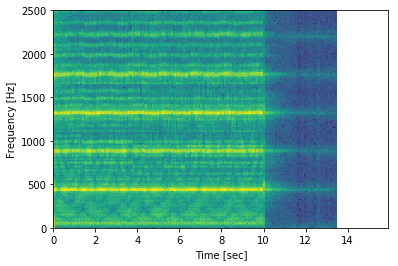

7353.58886719
441.430664062
0
0
Note is: A4


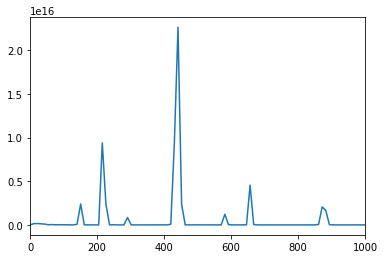

In [173]:
fname = './sound_files/A4_PopOrgan.aif'
find_notes(fname)

705600
44100
2
1.0
16.0
16 44100
(705600,)
352801


/Users/micbru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


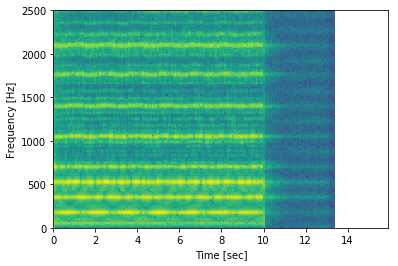

7353.58886719
172.265625
-16
-1
Note is: F3
705600
44100
2
1.0
16.0
16 44100
(705600,)
352801


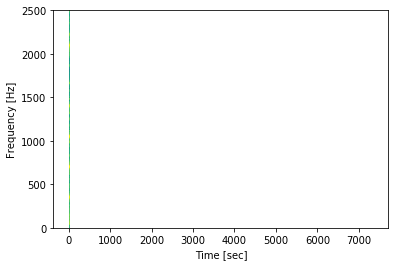

7353.58886719
699.829101562
8
0
Note is: F4


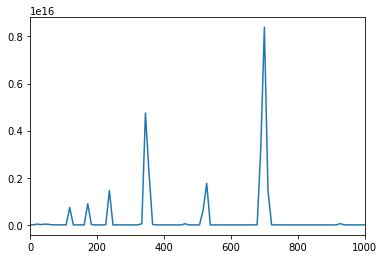

In [174]:
# Harmonics
fname = './sound_files/F3_PopOrgan.aif'
find_notes(fname)
fname = './sound_files/F4_CathedralOrgan.aif'
find_notes(fname)

705600
44100
2
1.0
16.0
16 44100
(705600,)
352801


/Users/micbru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


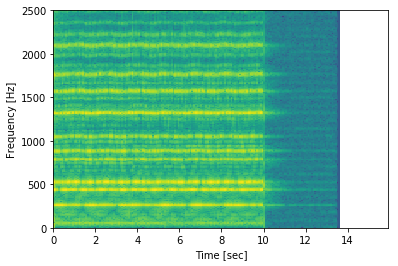

7353.58886719
441.430664062
0
0
Note is: A4


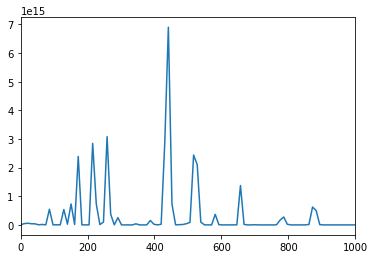

In [175]:
# Two notes:
fname = './sound_files/C4+A4_PopOrgan.aif'
find_notes(fname)

705600
44100
2
1.0
16.0
16 44100
(705600,)
352801


/Users/micbru/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:7176: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


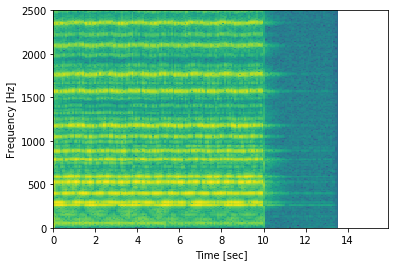

7353.58886719
258.3984375
-9
0
Note is: C4


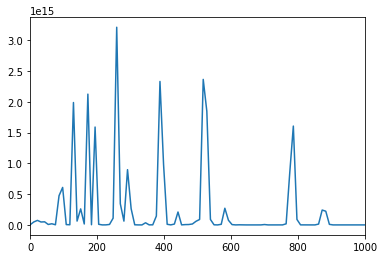

In [177]:
# Two notes:
fname = './sound_files/1.aif'
find_notes(fname)